In [1]:
import pandas as pd

use_cols = ["Date", "District", "Primary Type"]

df = pd.read_csv(
    "ChicagoCrimeData.csv",
    usecols=use_cols,
    parse_dates=["Date"]
)

df.info()

C:\Users\B Siddarth Vijayan\AppData\Local\Temp\ipykernel_2884\1648573733.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784664 entries, 0 to 7784663
Data columns (total 3 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Date          datetime64[ns]
 1   Primary Type  object        
 2   District      float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 178.2+ MB


In [2]:
df = df.dropna(subset=["District"])
df["District"] = df["District"].astype("int16")


In [3]:
df = df[df["Date"] >= "2015-01-01"]

In [4]:
df["week"] = df["Date"].dt.to_period("W").apply(lambda r: r.start_time)

In [5]:
weekly_df = (
    df.groupby(["week", "District"])
      .size()
      .reset_index(name="crime_count")
)

In [6]:
all_weeks = pd.date_range(
    weekly_df["week"].min(),
    weekly_df["week"].max(),
    freq="W-MON"
)

all_districts = weekly_df["District"].unique()

full_index = pd.MultiIndex.from_product(
    [all_weeks, all_districts],
    names=["week", "District"]
)

weekly_df = (
    weekly_df
    .set_index(["week", "District"])
    .reindex(full_index, fill_value=0)
    .reset_index()
)


In [8]:
weekly_df.groupby("District")["crime_count"].mean().sort_values()

District
31      0.177419
20     86.304147
17    135.576037
24    145.082949
22    153.972350
16    166.451613
14    166.516129
15    186.748848
5     209.152074
9     210.177419
2     211.235023
10    217.398618
19    218.486175
3     230.813364
12    244.714286
18    244.771889
1     245.762673
7     248.221198
25    249.274194
4     269.433180
6     297.656682
8     297.702765
11    323.926267
Name: crime_count, dtype: float64

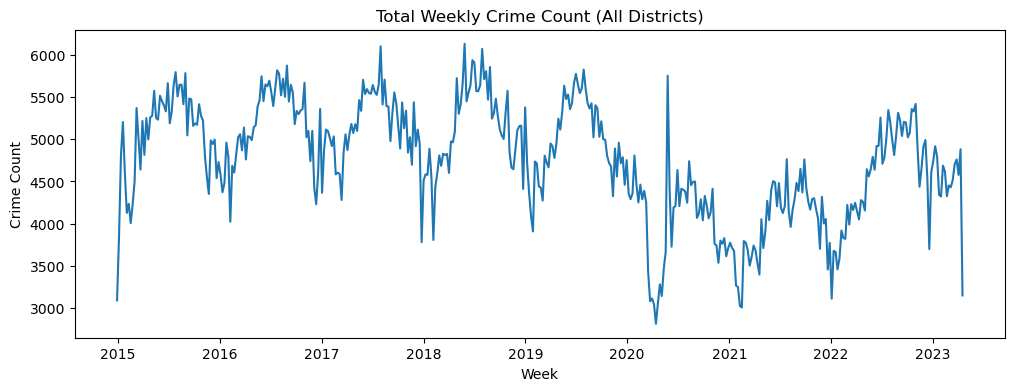

In [9]:
import matplotlib.pyplot as plt

city_weekly = weekly_df.groupby("week")["crime_count"].sum()

plt.figure(figsize=(12,4))
plt.plot(city_weekly)
plt.title("Total Weekly Crime Count (All Districts)")
plt.xlabel("Week")
plt.ylabel("Crime Count")
plt.show()


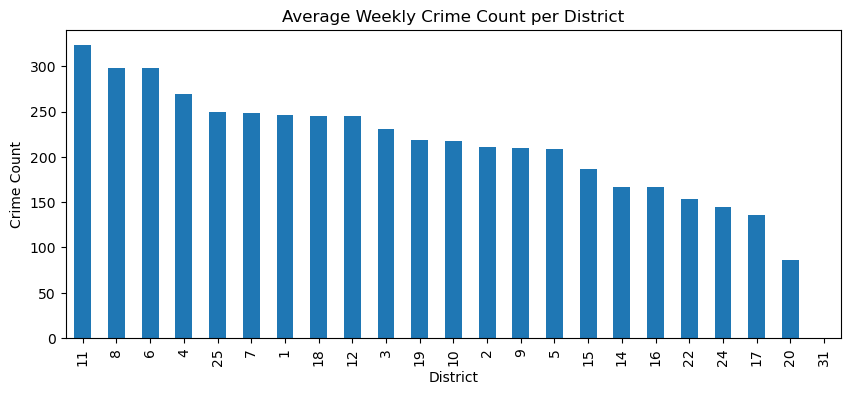

In [11]:
district_mean = (
    weekly_df.groupby("District")["crime_count"]
    .mean()
    .sort_values(ascending=False)
)

district_mean.head(10)
plt.figure(figsize=(10,4))
district_mean.plot(kind="bar")
plt.title("Average Weekly Crime Count per District")
plt.ylabel("Crime Count")
plt.show()


In [12]:
district_stats = weekly_df.groupby("District")["crime_count"].agg(
    mean="mean",
    std="std"
)

district_stats["cv"] = district_stats["std"] / district_stats["mean"]
district_stats.sort_values("cv", ascending=False).head()


,mean,std,cv
District,,,
31,0.177419,0.428054,2.412668
1,245.762673,72.851561,0.296431
18,244.771889,62.605595,0.255771
14,166.516129,35.536937,0.213414
7,248.221198,51.550571,0.207680


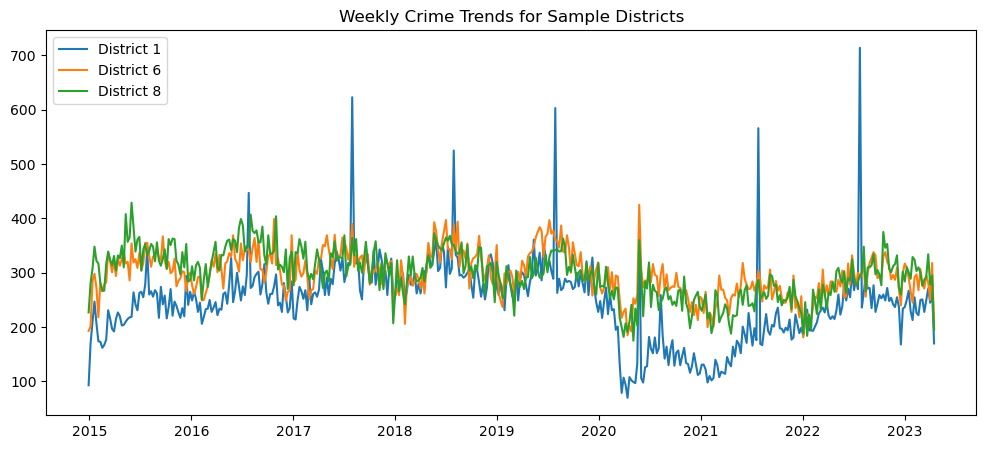

In [13]:
sample_districts = [1, 6, 8]

plt.figure(figsize=(12,5))
for d in sample_districts:
    temp = weekly_df[weekly_df["District"] == d]
    plt.plot(temp["week"], temp["crime_count"], label=f"District {d}")

plt.legend()
plt.title("Weekly Crime Trends for Sample Districts")
plt.show()


In [14]:
split_date = "2023-01-01"

train_df = weekly_df[weekly_df["week"] < split_date]
val_df   = weekly_df[weekly_df["week"] >= split_date]

In [15]:
train_df["week"].max(), val_df["week"].min()


(Timestamp('2022-12-26 00:00:00'), Timestamp('2023-01-02 00:00:00'))

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse


Model Building

In [17]:
# Sort to be safe
weekly_df = weekly_df.sort_values(["District", "week"])

# Create naive prediction (lag-1)
weekly_df["naive_pred"] = (
    weekly_df
    .groupby("District")["crime_count"]
    .shift(1)
)


In [18]:
val_naive = weekly_df.loc[val_df.index].dropna()


In [19]:
mae_naive, rmse_naive = evaluate(
    val_naive["crime_count"],
    val_naive["naive_pred"]
)

mae_naive, rmse_naive


(22.383152173913043, np.float64(31.15053736712851))

In [26]:
district_id = 6  # example

ts = (
    weekly_df[weekly_df["District"] == district_id]
    .set_index("week")["crime_count"]
    .sort_index()
)


<Axes: title={'center': 'Raw Weekly Crime Count'}, xlabel='week'>

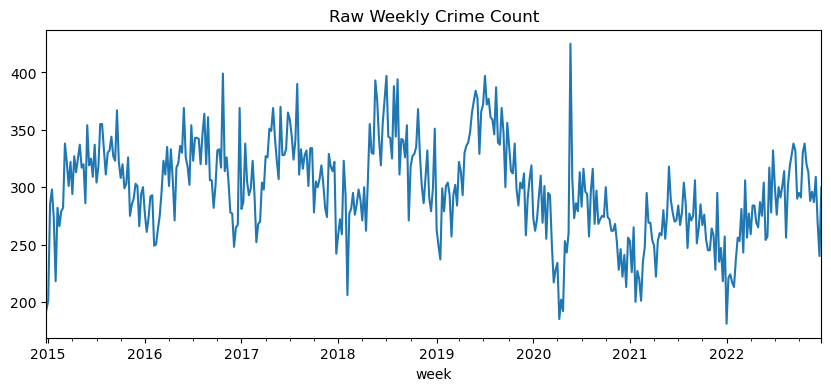

In [28]:
train_ts = ts[ts.index < split_date]
train_ts.plot(figsize=(10,4), title="Raw Weekly Crime Count")


In [30]:
diff_1 = train_ts.diff().dropna()
diff_seasonal = diff_1.diff(52).dropna()

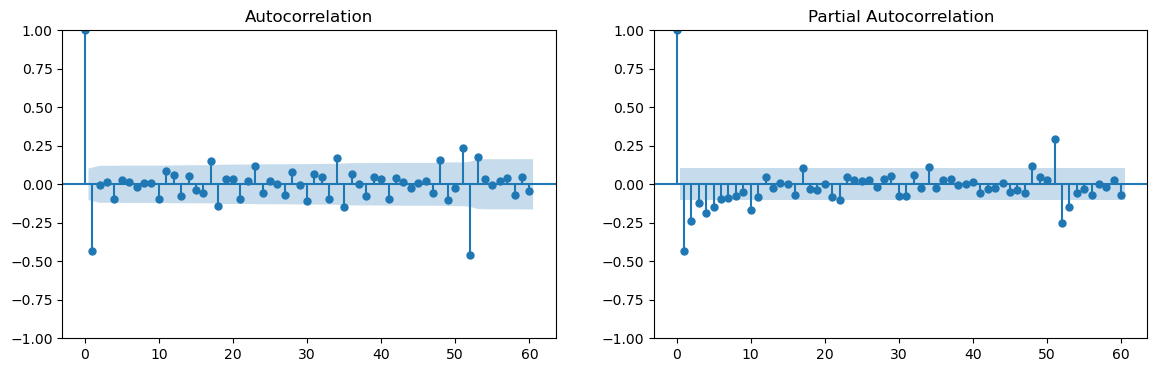

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,4))

plot_acf(diff_seasonal, lags=60, ax=axes[0])
plot_pacf(diff_seasonal, lags=60, ax=axes[1])

plt.show()


SARIMA(1,1,1)(1,1,1,52)

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train_ts,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = model.fit(disp=False)
print(sarima_result.summary())


c:\Users\B Siddarth Vijayan\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\B Siddarth Vijayan\anaconda3\envs\tsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        crime_count   No. Observations:                  418
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1499.646
Date:                            Fri, 26 Dec 2025   AIC                           3009.293
Time:                                    16:11:32   BIC                           3027.991
Sample:                                12-29-2014   HQIC                          3016.767
                                     - 12-26-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1804      0.070      2.563      0.010       0.042       0.318
ma.L1         -0.8524      0.028   

In [34]:
forecast = sarima_result.forecast(steps=len(val_ts))

mae_sarima, rmse_sarima = evaluate(val_ts.values, forecast.values)
mae_sarima, rmse_sarima


(42.19220695188492, np.float64(49.99304284087939))

SARIMA Performed Poorly (Key Reasons)

🔴 Reason 1: Structural Break (COVID)

SARIMA assumes:
Stable data-generating process
Your data has:
A major regime shift in 2020

SARIMA:
Tries to average pre- and post-2020 behavior
Fails badly in validation

🔴 Reason 2: Long Seasonal Period (52)

Seasonal SARIMA with:
s = 52
d = 1, D = 1

Means:
Heavy differencing
Loss of signal
High variance forecasts

🔴 Reason 3: District-Level Noise

You fit SARIMA on:
One district
No cross-district learning

District crime is:
Noisy
Influenced by many external factors

SARIMA can’t use:
Other districts
Calendar effects
Regime indicators

Machine Learning Forecasting

In [45]:
weekly_df = weekly_df.sort_values(["District", "week"]).reset_index(drop=True)


In [46]:
LAGS = [1, 2, 4, 8]

for lag in LAGS:
    weekly_df[f"lag_{lag}"] = (
        weekly_df
        .groupby("District")["crime_count"]
        .shift(lag)
    )


In [47]:
weekly_df["roll_mean_3"] = (
    weekly_df
    .groupby("District")["crime_count"]
    .shift(1)
    .rolling(3)
    .mean()
)

weekly_df["roll_std_3"] = (
    weekly_df
    .groupby("District")["crime_count"]
    .shift(1)
    .rolling(3)
    .std()
)


In [48]:
weekly_df["week_of_year"] = weekly_df["week"].dt.isocalendar().week.astype(int)
weekly_df["month"] = weekly_df["week"].dt.month
weekly_df["year"] = weekly_df["week"].dt.year


In [49]:
weekly_df["sin_week"] = np.sin(2 * np.pi * weekly_df["week_of_year"] / 52)
weekly_df["cos_week"] = np.cos(2 * np.pi * weekly_df["week_of_year"] / 52)


In [50]:
weekly_df["District"] = weekly_df["District"].astype(int)

In [51]:
feature_cols = (
    [f"lag_{l}" for l in LAGS] +
    ["roll_mean_3", "roll_std_3",
     "week_of_year", "month", "year",
     "sin_week", "cos_week",
     "District"]
)


In [52]:
model_df = weekly_df.dropna(subset=feature_cols + ["crime_count"])


In [53]:
split_date = "2023-01-01"

X_train = model_df[model_df["week"] < split_date][feature_cols]
y_train = model_df[model_df["week"] < split_date]["crime_count"]

X_val = model_df[model_df["week"] >= split_date][feature_cols]
y_val = model_df[model_df["week"] >= split_date]["crime_count"]


In [54]:
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    random_state=42
)

model.fit(
    X_train,
    y_train,
    categorical_feature=["District"]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1715
[LightGBM] [Info] Number of data points in the train set: 9430, number of used features: 12
[LightGBM] [Info] Start training from score 207.796501


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [55]:
y_pred = model.predict(X_val)


In [56]:
mae_ml, rmse_ml = evaluate(y_val, y_pred)

mae_ml, rmse_ml


(21.872456350567514, np.float64(29.862236613085102))

Improved ERROR value than SARIMA

In [57]:
importances = pd.Series(
    model.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

importances


lag_8           1773
roll_std_3      1653
lag_4           1614
roll_mean_3     1474
lag_1           1472
lag_2           1443
week_of_year    1254
year            1096
District        1088
cos_week        1052
sin_week         865
month            216
dtype: int32

TRYING TO IMPORVE THE PERFORMANCE USING DL

In [58]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [59]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse


In [60]:
dl_df = weekly_df[["week", "District", "crime_count"]].copy()
dl_df = dl_df.sort_values(["District", "week"]).reset_index(drop=True)


In [61]:
split_date = "2023-01-01"

train_df = dl_df[dl_df["week"] < split_date]
val_df   = dl_df[dl_df["week"] >= split_date]


In [62]:
scaler = StandardScaler()

train_df["crime_scaled"] = scaler.fit_transform(
    train_df[["crime_count"]]
)

val_df["crime_scaled"] = scaler.transform(
    val_df[["crime_count"]]
)


C:\Users\B Siddarth Vijayan\AppData\Local\Temp\ipykernel_2884\529947011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["crime_scaled"] = scaler.fit_transform(
C:\Users\B Siddarth Vijayan\AppData\Local\Temp\ipykernel_2884\529947011.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["crime_scaled"] = scaler.transform(


Sliding window logic

In [63]:
def create_sequences(df, window=8):
    X, y = [], []

    for district, group in df.groupby("District"):
        values = group["crime_scaled"].values
        
        for i in range(window, len(values)):
            X.append(values[i-window:i])
            y.append(values[i])

    return np.array(X), np.array(y)


In [64]:
WINDOW = 8

X_train, y_train = create_sequences(train_df, window=WINDOW)
X_val, y_val     = create_sequences(val_df, window=WINDOW)

# Add feature dimension
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]

X_train.shape, X_val.shape


((9430, 8, 1), (184, 8, 1))

In [65]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    
    LSTM(32),
    Dropout(0.2),
    
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


c:\Users\B Siddarth Vijayan\anaconda3\envs\tsenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1046 - val_loss: 0.1580
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1040 - val_loss: 0.1614
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1050 - val_loss: 0.1549
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1053 - val_loss: 0.1613
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1050 - val_loss: 0.1616
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1047 - val_loss: 0.1604
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1045 - val_loss: 0.1570
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1039 - val_loss: 0.1572


In [72]:
y_val_pred_scaled = model.predict(X_val)

y_val_pred = scaler.inverse_transform(y_val_pred_scaled)
y_val_true = scaler.inverse_transform(y_val.reshape(-1, 1))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [73]:
mae_lstm, rmse_lstm = evaluate(y_val_true, y_val_pred)

mae_lstm, rmse_lstm


(22.990000890648883, np.float64(32.240828516533206))

Compare Across ALL Models (This Is the Right Way)

Let’s put everything side by side 👇

Model	                 MAE	        RMSE
Naive / Moving Avg	     ~22.38     	~31.15
SARIMA                   ~42.19	        ~49.99
LightGBM (ML)             21.87	         29.86 ✅
LSTM (DL)	              22.99	         32.24